In [1]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="veb/twitch-bert-base-cased-finetuned")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at veb/twitch-bert-base-cased-finetuned and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
classifier(["We are very happy to show you the 🤗 Transformers library.", 
            "Now Playing: JAI - VIP Mix by Finesu -> ***",
            "I kind of like you", 
           "french people yikes", 
           "LESGOOOOO", 
           "POGGERS we we",
           "this is WICKED",
           "Leather Daddy"])

[{'label': 'LABEL_0', 'score': 0.5084452033042908},
 {'label': 'LABEL_0', 'score': 0.5036385655403137},
 {'label': 'LABEL_0', 'score': 0.520766019821167},
 {'label': 'LABEL_0', 'score': 0.5165353417396545},
 {'label': 'LABEL_0', 'score': 0.5349821448326111},
 {'label': 'LABEL_0', 'score': 0.5212324857711792},
 {'label': 'LABEL_0', 'score': 0.5330868363380432},
 {'label': 'LABEL_0', 'score': 0.5284669995307922}]

In [39]:
import pandas as pd
import numpy as np
# train_data = pd.read_csv('../data/processed/DistillBERT_training.csv')
train_data = pd.read_csv('../data/processed/streamer_data.csv')
train_data = train_data[['text', 'sentiment_v']]
train_data = train_data[train_data.sentiment_v.notnull()]
train_data = train_data.rename(columns={"sentiment_v": "label"})

In [40]:
train_data['label'] = np.where(train_data['label'] == 1, 1, train_data['label'])
train_data['label'] = np.where(train_data['label'] == 0, 1, train_data['label'])
train_data['label'] = np.where(train_data['label'] == -1, 0, train_data['label'])

In [41]:
train_data

,text,label
0,I got sick in December and am only just now fu...,0.0
1,!rp,1.0
2,"= RP Stats = | Current Amount: 14,956 RP || 32...",1.0
3,@Pr11me_ You buy i eat,1.0
4,how many days are you staying in the hospital ...,1.0
...,...,...
15578,forsenE,0.0
15579,FROZEN LUL FROZEN LUL FROZEN LUL FROZEN LUL...,1.0
15580,YEP,1.0
15582,can we get a bet,1.0


In [42]:
from datasets import Dataset 
bert_dataset = Dataset.from_pandas(train_data, preserve_index=False)
bert_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 5033
})

In [43]:
from transformers import AutoTokenizer, RobertaTokenizer
# tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("veb/twitch-bert-base-cased-finetuned")

In [44]:
def tokenize_function(examples):
    # return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=4)
    # return tokenizer(examples["text"], max_length=4)
    return tokenizer(examples["text"], padding="max_length", truncation=True)


In [45]:
tokenized_datasets_v2 = bert_dataset.map(tokenize_function, batched=True)

small_train_dataset_v2 = tokenized_datasets_v2.shuffle(seed=42).select(range(4530))
small_eval_dataset_v2 = tokenized_datasets_v2.shuffle(seed=42).select(range(503))

  0%|          | 0/6 [00:00<?, ?ba/s]

In [46]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [47]:
tf_train_dataset = small_train_dataset_v2.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset_v2.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

In [22]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

# model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = TFAutoModelForSequenceClassification.from_pretrained("veb/twitch-bert-base-cased-finetuned")


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at veb/twitch-bert-base-cased-finetuned and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers.keras_callbacks import PushToHubCallback

In [24]:
push_to_hub_callback = PushToHubCallback(
    output_dir="../models/twitch-bert-base-cased-finetuned", 
    tokenizer=tokenizer, 
    hub_model_id="veb/twitch-bert-base-cased-finetuned"
)

Cloning https://huggingface.co/veb/twitch-bert-base-cased-finetuned into local empty directory.


Download file tf_model.h5:   0%|          | 18.4k/500M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/500M [00:00<?, ?B/s]

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

In [48]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3, callbacks=push_to_hub_callback)

Epoch 1/3
566/566 [==============================] - ETA: 0s - loss: 0.2929 - sparse_categorical_accuracy: 0.8768 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcd61f8db00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
566/566 [==============================] - 17149s 30s/step - loss: 0.2929 - sparse_categorical_accuracy: 0.8768 - v

KeyboardInterrupt: 

In [49]:
from transformers import pipeline, AutoModelForTokenClassification

tokenizer = AutoModelForTokenClassification.from_pretrained("veb/twitch-bert-base-cased-finetuned", 
                                                            from_tf=True)
classifier = pipeline("sentiment-analysis", 
                      model="veb/twitch-bert-base-cased-finetuned")

All TF 2.0 model weights were used when initializing BertForTokenClassification.

All the weights of BertForTokenClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForTokenClassification for predictions without further training.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at veb/twitch-bert-base-cased-finetuned and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
classifier(['MonkaS PogChamp', 'PepeLaugh', 'MonkaS', 'CmonBruh', 'CmonBruh MonkaS', 'Kreygasm'])

[{'label': 'LABEL_1', 'score': 0.5210604667663574},
 {'label': 'LABEL_1', 'score': 0.5410008430480957},
 {'label': 'LABEL_1', 'score': 0.5246182084083557},
 {'label': 'LABEL_1', 'score': 0.5205326676368713},
 {'label': 'LABEL_1', 'score': 0.5255730748176575},
 {'label': 'LABEL_1', 'score': 0.5198141932487488}]

In [11]:
import pandas as pd 
text_df = pd.read_csv('../data/Fact Tables/EmoteFactTable.csv')
twitch_chats = text_df['Definition 1'].tolist()
list_polarity = classifier(twitch_chats)
list_polarity_label = []
for t, result in zip(twitch_chats, list_polarity):
    print(f"Text: {t[:50]},  label: {result['label']}, with score: {round(result['score'], 4)}")
    score = 0
    if result['label']=='NEGATIVE':
        score = -1 * round(result['score'], 4)
    else:
        score = round(result['score'], 4)
    # list_polarity_label.append(result['label'].upper())
    list_polarity_label.append(score)

Text: Kappa is a Twitch emote that is generally used to ,  label: NEGATIVE, with score: 0.81
Text: The acronym LUL stands for “Lame Uncomfortable Lau,  label: NEGATIVE, with score: 0.8951
Text: The TriHard Twitch emote was created to be used wh,  label: POSITIVE, with score: 0.715
Text: The PogChamp emote is used to express surprise or ,  label: POSITIVE, with score: 0.9595
Text: The PogChamp emote is used to express surprise or ,  label: POSITIVE, with score: 0.9595
Text: The PogChamp emote is used to express surprise or ,  label: POSITIVE, with score: 0.9595
Text: MonkaS is an emote that is often used in Twitch ch,  label: NEGATIVE, with score: 0.8026
Text: VoHiYo is known by Twitch viewers as the “Weeb” (W,  label: NEGATIVE, with score: 0.836
Text: The emote is used as a laugh emote on Twitch.,  label: NEGATIVE, with score: 0.7802
Text: The PepeLaugh emote is often accompanied by the ph,  label: POSITIVE, with score: 0.807
Text: The 4Head emote is used in response to jokes or me,  l

In [12]:
list_polarity_label

[-0.81,
 -0.8951,
 0.715,
 0.9595,
 0.9595,
 0.9595,
 -0.8026,
 -0.836,
 -0.7802,
 0.807,
 0.8974,
 0.9369,
 -0.9142,
 -0.8024,
 0.851,
 -0.7323,
 0.9199,
 -0.6929,
 -0.8473,
 -0.8633,
 -0.8606,
 0.8736,
 -0.9018,
 -0.9058,
 0.9828,
 0.5403,
 -0.9056,
 -0.847,
 0.9471,
 -0.8232,
 -0.8687,
 0.772,
 0.9314,
 -0.8502,
 -0.8646,
 -0.9311,
 0.7577,
 -0.9766,
 -0.5307,
 -0.8911,
 0.9527,
 0.542,
 0.7693,
 -0.9149,
 0.899,
 0.9654,
 -0.624,
 0.9521,
 -0.8667,
 -0.905,
 -0.9559,
 -0.8981,
 0.9842,
 -0.8983,
 0.7244,
 -0.6606,
 -0.6467,
 0.7891,
 -0.8407,
 -0.8722,
 -0.8807,
 0.9908,
 0.9037,
 -0.9046,
 0.993,
 -0.8852,
 -0.8272,
 -0.7094]

In [15]:
pd.Series(list_polarity_label).ewm(span=10).mean()

0    -0.810000
1    -0.856805
2    -0.224950
3     0.165274
4     0.393274
        ...   
63   -0.150086
64    0.057748
65   -0.113697
66   -0.243425
67   -0.328148
Length: 68, dtype: float64

In [16]:
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

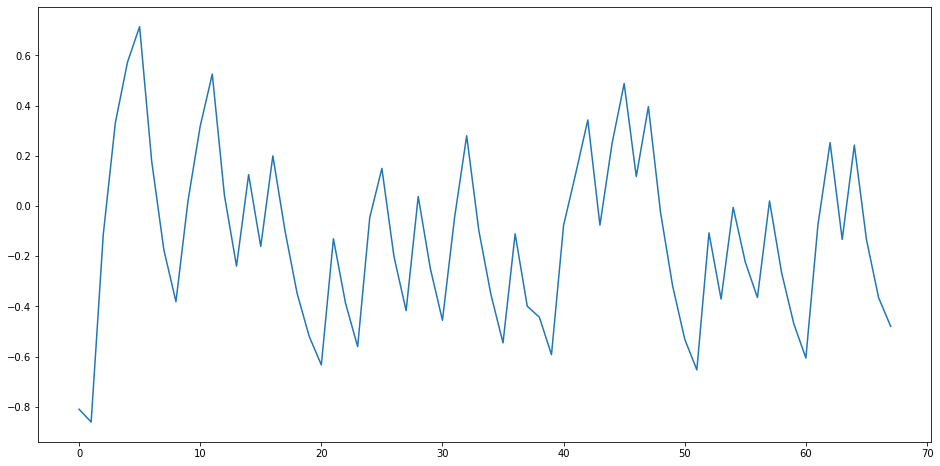

In [20]:
pd.Series(list_polarity_label).ewm(span=5).mean().plot(label='RELIANCE',
                                   figsize=(16, 8))